In [3]:
import sys
import getopt
import pandas as pd
import numpy as np
from fancyimpute import KNN
from multiprocessing import Pool
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# Set variables and defaults
input_profiles = '../data/profiles.csv'
input_layers = '../data/layers.csv'
input_file = ''
outputfile = '../data/classified_data.csv'
threshold = 0.01
#country_filter = ''
country_filter = 'MX'
knn = 0

profiles = pd.read_csv(input_profiles)
layers = pd.read_csv(input_layers)

print('Merging and cleaning data.')

# Selecting only those classified using WRB
classified_profiles = profiles[~profiles['cwrb_reference_soil_group'].isnull(
)]

# Merging of the files
classified_data = layers.merge(classified_profiles, how="inner", left_on=[
    'profile_id'], right_on=['profile_id'])

# Filter by country
if country_filter != '':
    classified_data = classified_data.loc[classified_data['country_id']
                                          == country_filter]

# Replace Albeluvisols with Retisols as was made in the latest version of WRB
classified_data.loc[classified_data['cwrb_reference_soil_group']
                    == 'Albeluvisols', 'cwrb_reference_soil_group'] = 'Retisols'

# Drop columns that are not numeric / not necessary (licenses)
classified_data = classified_data.drop(columns=['dataset_id', 'country_id', 'cfao_version', 'cfao_major_group',
                                                'cwrb_version', 'cwrb_reference_soil_group', 'cstx_version',
                                                'cstx_order_name', 'translated', 'profile_layer_id'])
classified_data = classified_data.drop(columns=list(
    classified_data.loc[:, classified_data.columns.str.contains('license')]))

# Remove the columns that have only missing values
classified_data = classified_data.dropna(axis=1, how='all')

# Remove all columns with more null values than allowed by the threshold
c = classified_data.count().apply(lambda x: x/classified_data.shape[0])
classified_data = classified_data.drop(
    columns=c[c < threshold].index.tolist())

# Remove rows where lower depth is clearly outlier
classified_data = classified_data[classified_data.lower_depth < 999]

# Add Thickness
classified_data['thickness'] = classified_data.apply(
    lambda row: row['lower_depth'] - row['upper_depth'], axis=1)

print('Cleaned data has {} rows and {} columns'.format(
    classified_data.shape[0], classified_data.shape[1]) + (', filtered by {}'.format(country_filter) if country_filter != '' else ''))



Merging and cleaning data.
Cleaned data has 19440 rows and 14 columns, filtered by MX


In [15]:
classified_data.columns = ['Profile Id', 'Upper Depth [cm]', 'Lower Depth [cm]', 'Calcium Carbonate Equivalent Total [g/kg]',
       'Average Clay [g/100g]', 'Electrical conductivity - saturated paste [dS/m]', 'Average Organic Carbon [g/kg]',
       'Average pH measured in H2O', 'Average Sand [g/100g]', 'Average Silt [g/100]', 'Latitude',
       'Longitude', 'Layer Thickness [cm]']

In [16]:
classified_data["Number of Layers"] = 0

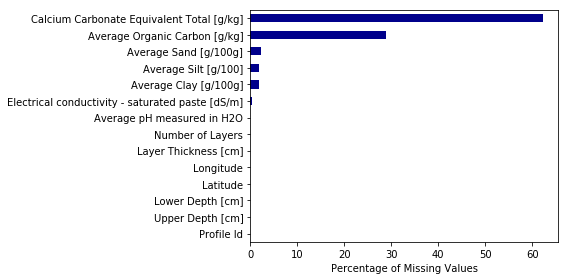

In [5]:

plt.figure(figsize=(8,4))
classified_data.isna().sum().divide(classified_data.shape[0]).multiply(100).sort_values(ascending=True).plot(kind='barh', color="darkblue")
plt.xlabel("Percentage of Missing Values")
plt.tight_layout()
plt.savefig("count_nulls.pdf")
plt.show()

In [28]:
df = classified_data
df[df['tceq_value_avg'].isnull()]['cwrb_reference_soil_group'].value_counts()

Vertisols      1678
Regosols       1614
Phaeozems      1435
Calcisols      1294
Luvisols       1090
Cambisols       891
Solonchaks      644
Leptosols       479
Kastanozems     391
Chernozems      340
Gleysols        329
Fluvisols       314
Arenosols       301
Umbrisols       291
Solonetz        237
Acrisols        226
Planosols       183
Andosols        164
Gypsisols        80
Nitisols         64
Durisols         46
Lixisols         26
Histosols        12
Name: cwrb_reference_soil_group, dtype: int64

In [16]:

classified_data[classified_data['profile_id'] == 205798].iloc[-1]


profile_id                     205798
upper_depth                        70
lower_depth                       115
tceq_value_avg                    NaN
clay_value_avg                      2
elcosp_value_avg                    1
orgc_value_avg                    NaN
phaq_value_avg                    7.5
sand_value_avg                     92
silt_value_avg                      6
latitude                      16.0087
longitude                    -97.4131
cwrb_reference_soil_group    Regosols
thickness                          45
Name: 44409, dtype: object

In [34]:
profile_ids = classified_data.profile_id.unique()

profiles = []
for i, id in enumerate(profile_ids):
    if i%1000 ==0 :
        print(i)
    # Find the layers for this profile and sort them
    layers = classified_data[classified_data['profile_id'] == id]
    layer = layers.iloc[-1].copy()
    layer['thickness'] = np.average(layers['thickness'])
    layer['n_layers'] = len(layers)
    #layers = layers.sort_values(by=['profile_id','lower_depth'])
    profiles.append(layer)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700


In [35]:
df = pd.DataFrame(profiles)
df.to_csv('only_last_layer.csv')

In [36]:
df.thickness

44409    28.750000
44933    26.250000
45202    17.500000
45614    25.000000
45994    21.500000
41257    28.750000
41544    22.500000
42137    23.666667
42879    20.000000
43199    17.400000
43799    25.000000
44226    17.500000
44266    20.833333
44271    19.000000
44413    25.000000
44446    14.000000
44498    21.000000
44499    27.000000
44593    38.666667
44596    15.500000
44637    19.400000
44638    30.000000
44737    26.500000
55341    28.666667
55348    17.571429
55350    12.500000
43312    33.333333
55351    18.000000
55355    31.750000
55357    15.000000
           ...    
52043    20.250000
52047     8.000000
52048    23.000000
52049    14.333333
52054    18.500000
52057    18.000000
52062    12.666667
52064    23.500000
52065    11.500000
52068    10.500000
52071    25.000000
52076    22.000000
52078    20.833333
16312     6.000000
52086    11.500000
16314    20.000000
52087    12.000000
52089    12.000000
52094    20.833333
52096     9.000000
52099    17.857143
52104    28.